# Modeling the Decomposition Reaction of HAN in a Catalyst Bed Rocket
By Team Han Solo

# Section 1: Initialization

First, it is important to import the necessary modules.

In [1]:
import numpy as np
import cantera as ct
from scipy import optimize
from scipy.integrate import solve_ivp
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import widgets, interact, fixed, Layout
from IPython.display import display
import seaborn as sbn

Then, the geometry of the reaction catalyst bed must be defined. The following variables are treated as the constants of the system. Some of the variables below are given in a range of inputs that the user can change through the use of widget sliders.

In [2]:
# Define Constants. Work in SI units only to avoid excessive consersion.
bed_diameter = 0.05 # fixed bed diameter of 5 cm
bed_cross_section_area = np.pi*bed_diameter**2/4
nozzle_diameter = 0.06 # fixed nozzle diameter of 6 cm
ref_particle_diameter = 0.001
volume_void_fraction = 0.4 # assume packing efficiency is 0.6 for most packed beds
area_void_fraction = 0.3
effective_area = bed_cross_section_area*(1-area_void_fraction)
R = 8.314e-5 # gas constant in m^3-bar/K-mol
R_2 = 8.314 # gas constant in J/mol-K or m^3-Pa/K-mol or kg-m^2/(K-mol-s^2)
g = 9.81 # gravitational acceleration in m/s^2
Cp_HAN = 74.826 # heat capacity of HAN in J/(K-mol)

"""
Assume 4 HAN -> 3 N2O + 2 HNO3 +7H2O
species 0, 1, 2, 3 = HAN, N2O, HNO3, H2O
"""
MW = np.array([96, 44, 63, 18])
gas = ct.Solution('HAN.cti')

In [3]:
# Define range of variable parameters
particle_diameter_range = (0.002, 0.005) # 1-5 mm
bed_length_range = (0.05, 0.2) # range of bed length 5-20 cm
start_temperatre_range = (323, 473) # 50-200 C
feed_pressure_range = (20, 50) # 20-50 bar
mass_flow_rate_range = (0.04, 0.1)
nozzle_diamater_range = (0.01, 0.1) # range of nozzle diameter

# Section 2 - Define helper functions

## 2.1 - Functions for catalyst bed region simulation

The following functions are important in calculating the properties of the fuel, reaction, and changes across the engine chamber bed.

In [4]:
def f_MW_mixture(x):
    """
    returns average molecular weight of mixture
    x is a numpy array containing mole fraction of each of the four species
    """
    return sum(MW*x)

In [5]:
def f_viscosity_HAN(T):
    """
    returns the approximated viscosity of HAN in kg/m-s, using water as an approximation
    from DIPPR database (water vapor)
    """
    if T > 646.15:
        A = 1.7096*1e-8
        B = 1.1146
        return A*T**B    
    else:
        A = -52.843
        B = 3703.6
        C = 5.866
        D = -5.879*1e-29
        E = 10
        return np.exp(A+B/T+C*np.log(T)+(D*T**E))

In [6]:
def f_viscosity(A, B, T):
    """
    returns viscosity in kg/m-s
    """
    t1 = 2/(3*np.pi**(1.5))
    t2 = np.sqrt(A/1000*1.381*1e-23*T)
    t3 = (B/1e-12)**2
    return t1*t2/t3

In [7]:
def f_rate_constant(temperature, particle_diameter):
    """
    returns rate constant of HAN in s^-1
    temperature in K
    particle size in m
    constants are made up
    """
    rate_constant = np.exp(3.2)*np.exp(-8.86*1000/(R_2*temperature))
    return rate_constant*(ref_particle_diameter/particle_diameter)

In [8]:
def f_dPdZ(m, mu, rho, dp):
    """
    returns pressure drop in bar/m
    m is mass flow rate in kg/s
    G is bed loading factor in kg/(m^2-s)
    rho is average density in kg/m^3
    mu is average viscosity in Pa-s
    dp is particle diameter in m
    """
    rp = dp/2
    G = m/effective_area
    phi = volume_void_fraction
    t1 = 300*(1-phi)*mu/rp+1.75*G
    t2 = -2*G/(rho*rp)*(1-phi)/(phi**3)
    return t1*t2/1e5

In [9]:
def combined_ode(z, variables):
    N_HAN, N_N2O, N_HNO3, N_H2O, T, P, bed_length, particle_diameter, mass_flow_rate = variables
    if P<=0 or N_HAN<=0 or T<=0:
        return (0, 0, 0, 0, 0, 0, 0, 0, 0)
    N = np.array([N_HAN, N_N2O, N_HNO3, N_H2O])
    N_tot = sum(N)
    X = N/N_tot # mole fraction of each species
    MW_tot = f_MW_mixture(X)
    
    # obtain gas properties
    gas.TPX = T, P*1e5, 'han:{} n2o:{} hno3:{} h2o:{}'.format(X[0], X[1], X[2], X[3])
    Cp_tot = gas.cp_mole/1000 # heat capacity of mixture in 
    rho_tot = gas.DP[0] # density of mixture in 
    C_HAN = rho_tot/MW_tot*1000
    
    # Evaluate dT/dZ
    k = f_rate_constant(T, particle_diameter) # reaction constant in s^-1
    dH = -218400+Cp_HAN*(T-298) # enthalpy of reaction for 1 mole of HAN reacted in J/mol
    dTdZ = -k*C_HAN*dH*effective_area/Cp_tot

    # Evaluate dN/dZ
    r_HAN = -k*C_HAN*effective_area
    dNdZ = [r_HAN, -0.75*r_HAN, -0.5*r_HAN, -1.75*r_HAN]
    
    # Evaluate viscosity of mixture
    mu_HAN = f_viscosity_HAN(T)
    mu_other_gas = np.array([f_viscosity(44.01, 330, T), 
                             f_viscosity(63.01, 550, T),
                             f_viscosity(18.02, 140, T)])
    mu_tot = mu_HAN*X[0]+sum(mu_other_gas*X[1:])*(1-X[0])
    
    # Evaluate dP/dZ
    dPdZ = f_dPdZ(mass_flow_rate, mu_tot, rho_tot, particle_diameter)
    
    return (dNdZ[0], dNdZ[1], dNdZ[2], dNdZ[3], dTdZ, dPdZ, 0, 0, 0)

## 2.2 - Functions for de Laval nozzle region simulation

The following functions are used to calculate parameters in the de Laval nozzle region which leads to the thrust developed by the engine

In [10]:
def f_gamma(Cp):
    "returns specific heat ratio given heat capacity"
    return Cp/(Cp-R_2)

In [11]:
def helper_function_1(gamma):
    "A helper function to help calculate throat area and Mach number"
    return (gamma+1)/(2*gamma-2)

def f_throat_area(flow_rate, chamber_pressure, chamber_temperature, gamma, MW):
    """
    returns throat area in m^2
    flow rate in kg/s
    chamber temperature in K
    chamber pressure in bar
    MW in g/mol
    """
    t1 = helper_function_1(gamma)
    temp_R = R_2/MW*1000
    t2 = np.sqrt(gamma/temp_R)/((gamma+1)/2)**t1
    return flow_rate*np.sqrt(chamber_temperature)/(chamber_pressure*t2*1e5)

In [12]:
# given an expansion ratio and gamma value, solve for Mach number
def f_Mach_number(Expansion_ratio, gamma):
    # target for solver
    target = Expansion_ratio
    
    # function for expansion ratio vs. Mach number
    def f_expansion_ratio(Mach_number):
        t1 = helper_function_1(gamma)
        t2 = ((gamma+1)/2)**(-t1)
        t3 = (1+(gamma-1)/2*Mach_number*Mach_number)**t1/Mach_number
        return t2*t3-target
    
    sol = optimize.root_scalar(f_expansion_ratio, bracket = [-1, 50], method = 'brentq')
    return sol.root

In [13]:
def helper_function_2(Mach_number, gamma):
    "A helper function to help calculate exhaust temperature and pressure"
    return 1+(gamma-1)/2*Mach_number**2

def f_exhaust_temperature(chamber_temperature, gamma, Mach_number):
    "returns exhaust temperature in K"
    return chamber_temperature/helper_function_2(Mach_number, gamma)

def f_exhaust_pressure(chamber_pressure, gamma, Mach_number):
    "returns exhaust pressure in bar"
    return chamber_pressure/(helper_function_2(Mach_number, gamma)**(gamma/(gamma-1)))

In [14]:
def f_speed_of_sound(MW, gamma, T):
    """
    returns speed of sound in m/s
    R is gas constant in kg-m^2/(K-mol)
    MW is average molecular weight in g/mol
    gamma is average specific heat ratio
    T is temperature in K
    """
    return np.sqrt(gamma*R_2*T*1000/MW)

def f_exhaust_velocity(Mach_number, speed_of_sound):
    "returns exhaust velocity in m/s"
    return Mach_number*speed_of_sound

In [15]:
def f_thrust(Ue, flow_rate, nozzle_area, exhaust_pressure, ambient_pressure):
    """
    returns thrust in N
    Ue is exhaust velocity in m/s
    flow rate in kg/s
    nozzle area in m^2
    exhaust and ambient pressure in bar
    """
    return Ue*flow_rate+nozzle_area*(exhaust_pressure-ambient_pressure)*1e5

def f_Isp(thrust, flow_rate):
    """
    returns specific impulse in s
    thrust in N
    Ue is exhaust velocity in m/s
    """
    return thrust/(flow_rate*g)

# Section 3 - Main Simulation Code

## 3.1 - Single-pass Engine Parameter Calculator

This section of the notebook evaluates the model's ability to operate at the extremes of the parameters the user can set. The chosen parameters that are tested are the extremes for their respective inputs.

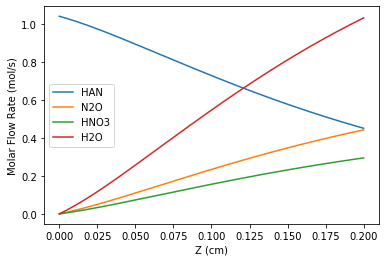

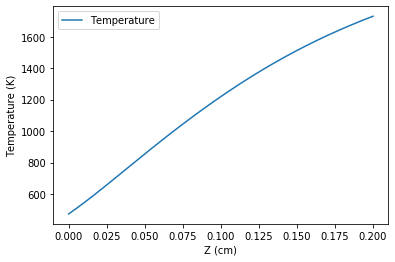

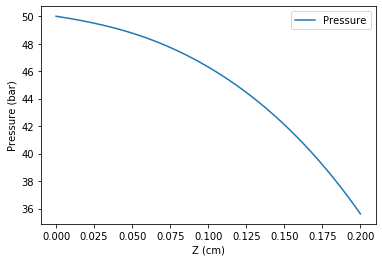

The conversion rate of HAN is 52.7%
The chamber temperature is 1730.6 K
The chamber pressure is 35.6 bar
The thrust developed by the engine is 182.6 N
The specific impulse of the engine is 186.2 s


In [16]:
bed_length = 0.2
particle_diameter = 0.002
mass_flow_rate = 0.1
feed_temperature = 473
feed_pressure = 50
user_inputs = [bed_length, particle_diameter, mass_flow_rate]

# define initial conditions
N = 1000
step_size = bed_length/N
Z_Array = np.linspace(0, bed_length, N+1)
molar_flow_rate = mass_flow_rate*1000/MW[0]
initial_conditions = (molar_flow_rate, 0, 0, 0, feed_temperature, feed_pressure, *user_inputs)

# solve for the system of ODEs
results = solve_ivp(combined_ode, (0, bed_length), initial_conditions, t_eval=Z_Array)

# plot the concentration profile
plt.plot(Z_Array, results.y[0], label='HAN')
plt.plot(Z_Array, results.y[1], label='N2O')
plt.plot(Z_Array, results.y[2], label='HNO3')
plt.plot(Z_Array, results.y[3], label='H2O')
plt.legend(loc='best')
plt.xlabel('Z (cm)')
plt.ylabel('Molar Flow Rate (mol/s)')
plt.show()

# plot the temperature profile
plt.plot(Z_Array, results.y[4], label='Temperature')
plt.legend(loc='best')
plt.xlabel('Z (cm)')
plt.ylabel('Temperature (K)')
plt.show()

# plot the pressure profile
plt.plot(Z_Array, results.y[5], label='Pressure')
plt.legend(loc='best')
plt.xlabel('Z (cm)')
plt.ylabel('Pressure (bar)')
plt.show()

# Rocket thrust calculation
chamber_temperature = results.y[4][-1]
chamber_pressure = results.y[5][-1]
N_exit = np.array([results.y[0][-1], results.y[1][-1], results.y[2][-1], results.y[3][-1]])
conversion_HAN = (1-N_exit[0])/molar_flow_rate
X = N_exit/sum(N_exit)
MW_tot = sum(MW*X)
gas.TPX = chamber_temperature, chamber_pressure*1e5, 'han:{} n2o:{} hno3:{} h2o:{}'.format(X[0], X[1], X[2], X[3])
Cp_tot = gas.cp_mole/1000
gamma = f_gamma(Cp_tot)
ambient_pressure = 0

# Obtain the values
nozzle_area = np.pi*nozzle_diameter*nozzle_diameter*0.25
throat_area = f_throat_area(mass_flow_rate, chamber_pressure, chamber_temperature, gamma, MW_tot)
expansion_ratio = nozzle_area/throat_area
Mach_number = f_Mach_number(expansion_ratio, gamma)
exhaust_temperature = f_exhaust_temperature(chamber_temperature, gamma, Mach_number)
exhaust_pressure = f_exhaust_pressure(chamber_pressure, gamma, Mach_number)
speed_of_sound = f_speed_of_sound(MW_tot, gamma, exhaust_temperature)
exhaust_velocity = f_exhaust_velocity(Mach_number, speed_of_sound)
thrust = f_thrust(exhaust_velocity, mass_flow_rate, nozzle_area, exhaust_pressure, ambient_pressure)
Isp = f_Isp(thrust, mass_flow_rate)

print('The conversion rate of HAN is {0:1.1%}'.format(conversion_HAN))
print('The chamber temperature is {0:1.1f}'.format(chamber_temperature), 'K')
print('The chamber pressure is {0:1.1f}'.format(chamber_pressure), 'bar')
print('The thrust developed by the engine is {0:.1f}'.format(thrust), 'N')
print('The specific impulse of the engine is {0:.1f}'.format(Isp),'s')


Now that the extreme cases for the model have been tested and function as expected, the user can use the below sliding widgets to change the various inputs of the system. The results for each input is printed out  as conversion rate, chamber temperature, chamber pressure, thrust, and specific impulse.


In [17]:
# function of engine parameters used for the interactive widget
from ipywidgets import FloatSlider
@interact
def engine_parameters(L=FloatSlider(value=10, min=5, max=20, step=0.1, description='bed length (cm)'), # cm
                      Dp=FloatSlider(value=3, min=2, max=5, step=0.1, description='particle diameter (mm)'), # mm
                      F0=FloatSlider(value=75, min=50, max=100, step=0.1, description='mass flow rate (g/s)'), # g/s
                      T0=FloatSlider(value=100, min=50, max=200, step=1., description='feed temperature (C)'), # C
                      P0=FloatSlider(value=20, min=20, max=50, step=1., description='feed pressure (bar)')): # bar
    # convert units
    bed_length = L/100 # cm to m
    particle_diameter = Dp/1000 # mm to m
    mass_flow_rate = F0/1000 # g/s to kg/s
    feed_temperature = T0+273.15 # C to K
    feed_pressure = P0
    user_inputs = [feed_temperature, feed_pressure, bed_length, particle_diameter, mass_flow_rate]
    
    # define initial conditions
    N = 1000
    step_size = bed_length/N
    Z_Array = np.linspace(0, bed_length, N+1)
    molar_flow_rate = mass_flow_rate*1000/MW[0]
    initial_conditions = (molar_flow_rate, 0, 0, 0, *user_inputs)

    # solve for the system of ODEs
    results = solve_ivp(combined_ode, (0, bed_length), initial_conditions, t_eval=Z_Array)
    
    # Obtain parameters at the end of the catalyst bed
    chamber_temperature = results.y[4][-1]
    chamber_pressure = results.y[5][-1]
    N_exit = np.array([results.y[0][-1], results.y[1][-1], results.y[2][-1], results.y[3][-1]])
    conversion_HAN = min(1, 1-N_exit[0]/molar_flow_rate)
    X = N_exit/sum(N_exit)
    MW_tot = sum(MW*X)
    gas.TPX = chamber_temperature, chamber_pressure*1e5, 'han:{} n2o:{} hno3:{} h2o:{}'.format(X[0], X[1], X[2], X[3])
    Cp_tot = gas.cp_mole/1000
    gamma = f_gamma(Cp_tot) # specific heat ratio
    ambient_pressure = 0 # the engine operates in vacuum

    # Obtain nozzle region parameters
    nozzle_area = np.pi*nozzle_diameter*nozzle_diameter*0.25
    throat_area = f_throat_area(mass_flow_rate, chamber_pressure, chamber_temperature, gamma, MW_tot)
    expansion_ratio = nozzle_area/throat_area
    
    Mach_number = f_Mach_number(expansion_ratio, gamma)
    exhaust_temperature = f_exhaust_temperature(chamber_temperature, gamma, Mach_number)
    exhaust_pressure = f_exhaust_pressure(chamber_pressure, gamma, Mach_number)
    
    speed_of_sound = f_speed_of_sound(MW_tot, gamma, exhaust_temperature)
    exhaust_velocity = f_exhaust_velocity(Mach_number, speed_of_sound)
    thrust = f_thrust(exhaust_velocity, mass_flow_rate, nozzle_area, exhaust_pressure, ambient_pressure)
    Isp = f_Isp(thrust, mass_flow_rate)
    
    if chamber_temperature >= 1600:
        # return an warning message when the temperature limit of 1600 K is exceeded
        print('Temperature exceeded catalyst limits, the engine will be unsafe to operate')
        return
    else:
        print('The conversion rate of HAN is {0:1.1%}'.format(conversion_HAN))
        print('The chamber temperature is {0:1.1f}'.format(chamber_temperature), 'K')
        print('The chamber pressure is {0:1.1f}'.format(chamber_pressure), 'bar')
        print('The thrust developed by the engine is {0:.1f}'.format(thrust), 'N')
        print('The specific impulse of the engine is {0:.1f}'.format(Isp),'s')
        return

interactive(children=(FloatSlider(value=10.0, description='bed length (cm)', max=20.0, min=5.0), FloatSlider(v…

# Section 4 - Sobol Sensitivity Analysis

To further evaluate the model, a sensitivity analysis on the inputs was performed. First, the following packages must be installed and imported.

In [18]:
import SALib
from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa

## 4.1 - Generating Sample Sets

To perform the analysis, sample sets must be generated. This is done by having the program randomly select a number within the parameter of each input. This combined set of randomly chosen inputs is done 7,000 times to generate 7,000 different sample sets. The more sample sets tested, the more reliable the results of the analysis are.

In [19]:
def sensitivity_func(bed_length, particle_diameter, mass_flow_rate, feed_temperature, feed_pressure):
    
    bed_length = bed_length/100
    particle_diameter = particle_diameter/1000
    mass_flow_rate = mass_flow_rate/1000
    feed_temperature = feed_temperature+273.15
    feed_pressure = feed_pressure
    
    user_inputs = [bed_length, particle_diameter, mass_flow_rate]
    
    # define initial conditions
    N = 1000
    step_size = bed_length/N
    Z_Array = np.linspace(0, bed_length, N+1)
    molar_flow_rate = mass_flow_rate*1000/MW[0]
    initial_conditions = (molar_flow_rate, 0, 0, 0, feed_temperature, feed_pressure, *user_inputs)

    # solve for the system of ODEs
    results = solve_ivp(combined_ode, (0, bed_length), initial_conditions, t_eval=Z_Array)
    
    chamber_temperature = results.y[4][-1]
    chamber_pressure = results.y[5][-1]
    N_exit = np.array([results.y[0][-1], results.y[1][-1], results.y[2][-1], results.y[3][-1]])
    conversion_HAN = (1-N_exit[0])/molar_flow_rate
    X = N_exit/sum(N_exit)
    MW_tot = sum(MW*X)
    gas.TPX = chamber_temperature, chamber_pressure*1e5, 'han:{} n2o:{} hno3:{} h2o:{}'.format(X[0], X[1], X[2], X[3])
    Cp_tot = gas.cp_mole/1000
    gamma = f_gamma(Cp_tot)
    ambient_pressure = 0
    
    nozzle_area = np.pi*nozzle_diameter*nozzle_diameter*0.25
    throat_area = f_throat_area(mass_flow_rate, chamber_pressure, chamber_temperature, gamma, MW_tot)
    expansion_ratio = nozzle_area/throat_area
    Mach_number = f_Mach_number(expansion_ratio, gamma)
    exhaust_temperature = f_exhaust_temperature(chamber_temperature, gamma, Mach_number)
    exhaust_pressure = f_exhaust_pressure(chamber_pressure, gamma, Mach_number)
    speed_of_sound = f_speed_of_sound(MW_tot, gamma, exhaust_temperature)
    exhaust_velocity = f_exhaust_velocity(Mach_number, speed_of_sound)
    thrust = f_thrust(exhaust_velocity, mass_flow_rate, nozzle_area, exhaust_pressure, ambient_pressure)
    Isp = f_Isp(thrust, mass_flow_rate)
    
    return results.y[:, -1], conversion_HAN, thrust, Isp

In [20]:
sobol_problem = {
    'num_vars': 5,
    'names': ['bed length', 'particle diameter', 'mass flow rate', 'feed temperature', 'feed pressure'],
    'bounds': [[5, 20], # bed length (cm)
               [2, 5], # particle diameter (mm)
               [50, 100], # mass flow rate (g/s)
               [50, 200], # feed temperature (C)
               [20, 50], # feed pressure (bar)
               ],
    'groups': None
    }
sobol_problem

{'num_vars': 5,
 'names': ['bed length',
  'particle diameter',
  'mass flow rate',
  'feed temperature',
  'feed pressure'],
 'bounds': [[5, 20], [2, 5], [50, 100], [50, 200], [20, 50]],
 'groups': None}

In [21]:
sample_sobol = ss(sobol_problem, 1000, calc_second_order=False)
number_of_runs = 1000*7

In [22]:
# Run the sample through the ode solver model to get results for each set
output_s = []
for i in range(len(sample_sobol.T[1])):
    packed_s = (sample_sobol.T[0][i], sample_sobol.T[1][i], sample_sobol.T[2][i], sample_sobol.T[3][i], sample_sobol.T[4][i])
    print(i, " out of ", number_of_runs)
    output_s.append(sensitivity_func(*packed_s))

0  out of  7000
1  out of  7000
2  out of  7000
3  out of  7000
4  out of  7000
5  out of  7000
6  out of  7000
7  out of  7000
8  out of  7000
9  out of  7000
10  out of  7000
11  out of  7000
12  out of  7000
13  out of  7000
14  out of  7000
15  out of  7000
16  out of  7000
17  out of  7000
18  out of  7000
19  out of  7000
20  out of  7000
21  out of  7000
22  out of  7000
23  out of  7000
24  out of  7000
25  out of  7000
26  out of  7000
27  out of  7000
28  out of  7000
29  out of  7000
30  out of  7000
31  out of  7000
32  out of  7000
33  out of  7000
34  out of  7000
35  out of  7000
36  out of  7000
37  out of  7000
38  out of  7000
39  out of  7000
40  out of  7000
41  out of  7000
42  out of  7000
43  out of  7000
44  out of  7000
45  out of  7000
46  out of  7000
47  out of  7000
48  out of  7000
49  out of  7000
50  out of  7000
51  out of  7000
52  out of  7000
53  out of  7000
54  out of  7000
55  out of  7000
56  out of  7000
57  out of  7000
58  out of  7000
59  out

475  out of  7000
476  out of  7000
477  out of  7000
478  out of  7000
479  out of  7000
480  out of  7000
481  out of  7000
482  out of  7000
483  out of  7000
484  out of  7000
485  out of  7000
486  out of  7000
487  out of  7000
488  out of  7000
489  out of  7000
490  out of  7000
491  out of  7000
492  out of  7000
493  out of  7000
494  out of  7000
495  out of  7000
496  out of  7000
497  out of  7000
498  out of  7000
499  out of  7000
500  out of  7000
501  out of  7000
502  out of  7000
503  out of  7000
504  out of  7000
505  out of  7000
506  out of  7000
507  out of  7000
508  out of  7000
509  out of  7000
510  out of  7000
511  out of  7000
512  out of  7000
513  out of  7000
514  out of  7000
515  out of  7000
516  out of  7000
517  out of  7000
518  out of  7000
519  out of  7000
520  out of  7000
521  out of  7000
522  out of  7000
523  out of  7000
524  out of  7000
525  out of  7000
526  out of  7000
527  out of  7000
528  out of  7000
529  out of  7000
530  out o

944  out of  7000
945  out of  7000
946  out of  7000
947  out of  7000
948  out of  7000
949  out of  7000
950  out of  7000
951  out of  7000
952  out of  7000
953  out of  7000
954  out of  7000
955  out of  7000
956  out of  7000
957  out of  7000
958  out of  7000
959  out of  7000
960  out of  7000
961  out of  7000
962  out of  7000
963  out of  7000
964  out of  7000
965  out of  7000
966  out of  7000
967  out of  7000
968  out of  7000
969  out of  7000
970  out of  7000
971  out of  7000
972  out of  7000
973  out of  7000
974  out of  7000
975  out of  7000
976  out of  7000
977  out of  7000
978  out of  7000
979  out of  7000
980  out of  7000
981  out of  7000
982  out of  7000
983  out of  7000
984  out of  7000
985  out of  7000
986  out of  7000
987  out of  7000
988  out of  7000
989  out of  7000
990  out of  7000
991  out of  7000
992  out of  7000
993  out of  7000
994  out of  7000
995  out of  7000
996  out of  7000
997  out of  7000
998  out of  7000
999  out o

1393  out of  7000
1394  out of  7000
1395  out of  7000
1396  out of  7000
1397  out of  7000
1398  out of  7000
1399  out of  7000
1400  out of  7000
1401  out of  7000
1402  out of  7000
1403  out of  7000
1404  out of  7000
1405  out of  7000
1406  out of  7000
1407  out of  7000
1408  out of  7000
1409  out of  7000
1410  out of  7000
1411  out of  7000
1412  out of  7000
1413  out of  7000
1414  out of  7000
1415  out of  7000
1416  out of  7000
1417  out of  7000
1418  out of  7000
1419  out of  7000
1420  out of  7000
1421  out of  7000
1422  out of  7000
1423  out of  7000
1424  out of  7000
1425  out of  7000
1426  out of  7000
1427  out of  7000
1428  out of  7000
1429  out of  7000
1430  out of  7000
1431  out of  7000
1432  out of  7000
1433  out of  7000
1434  out of  7000
1435  out of  7000
1436  out of  7000
1437  out of  7000
1438  out of  7000
1439  out of  7000
1440  out of  7000
1441  out of  7000
1442  out of  7000
1443  out of  7000
1444  out of  7000
1445  out of

1836  out of  7000
1837  out of  7000
1838  out of  7000
1839  out of  7000
1840  out of  7000
1841  out of  7000
1842  out of  7000
1843  out of  7000
1844  out of  7000
1845  out of  7000
1846  out of  7000
1847  out of  7000
1848  out of  7000
1849  out of  7000
1850  out of  7000
1851  out of  7000
1852  out of  7000
1853  out of  7000
1854  out of  7000
1855  out of  7000
1856  out of  7000
1857  out of  7000
1858  out of  7000
1859  out of  7000
1860  out of  7000
1861  out of  7000
1862  out of  7000
1863  out of  7000
1864  out of  7000
1865  out of  7000
1866  out of  7000
1867  out of  7000
1868  out of  7000
1869  out of  7000
1870  out of  7000
1871  out of  7000
1872  out of  7000
1873  out of  7000
1874  out of  7000
1875  out of  7000
1876  out of  7000
1877  out of  7000
1878  out of  7000
1879  out of  7000
1880  out of  7000
1881  out of  7000
1882  out of  7000
1883  out of  7000
1884  out of  7000
1885  out of  7000
1886  out of  7000
1887  out of  7000
1888  out of

2272  out of  7000
2273  out of  7000
2274  out of  7000
2275  out of  7000
2276  out of  7000
2277  out of  7000
2278  out of  7000
2279  out of  7000
2280  out of  7000
2281  out of  7000
2282  out of  7000
2283  out of  7000
2284  out of  7000
2285  out of  7000
2286  out of  7000
2287  out of  7000
2288  out of  7000
2289  out of  7000
2290  out of  7000
2291  out of  7000
2292  out of  7000
2293  out of  7000
2294  out of  7000
2295  out of  7000
2296  out of  7000
2297  out of  7000
2298  out of  7000
2299  out of  7000
2300  out of  7000
2301  out of  7000
2302  out of  7000
2303  out of  7000
2304  out of  7000
2305  out of  7000
2306  out of  7000
2307  out of  7000
2308  out of  7000
2309  out of  7000
2310  out of  7000
2311  out of  7000
2312  out of  7000
2313  out of  7000
2314  out of  7000
2315  out of  7000
2316  out of  7000
2317  out of  7000
2318  out of  7000
2319  out of  7000
2320  out of  7000
2321  out of  7000
2322  out of  7000
2323  out of  7000
2324  out of

2718  out of  7000
2719  out of  7000
2720  out of  7000
2721  out of  7000
2722  out of  7000
2723  out of  7000
2724  out of  7000
2725  out of  7000
2726  out of  7000
2727  out of  7000
2728  out of  7000
2729  out of  7000
2730  out of  7000
2731  out of  7000
2732  out of  7000
2733  out of  7000
2734  out of  7000
2735  out of  7000
2736  out of  7000
2737  out of  7000
2738  out of  7000
2739  out of  7000
2740  out of  7000
2741  out of  7000
2742  out of  7000
2743  out of  7000
2744  out of  7000
2745  out of  7000
2746  out of  7000
2747  out of  7000
2748  out of  7000
2749  out of  7000
2750  out of  7000
2751  out of  7000
2752  out of  7000
2753  out of  7000
2754  out of  7000
2755  out of  7000
2756  out of  7000
2757  out of  7000
2758  out of  7000
2759  out of  7000
2760  out of  7000
2761  out of  7000
2762  out of  7000
2763  out of  7000
2764  out of  7000
2765  out of  7000
2766  out of  7000
2767  out of  7000
2768  out of  7000
2769  out of  7000
2770  out of

3161  out of  7000
3162  out of  7000
3163  out of  7000
3164  out of  7000
3165  out of  7000
3166  out of  7000
3167  out of  7000
3168  out of  7000
3169  out of  7000
3170  out of  7000
3171  out of  7000
3172  out of  7000
3173  out of  7000
3174  out of  7000
3175  out of  7000
3176  out of  7000
3177  out of  7000
3178  out of  7000
3179  out of  7000
3180  out of  7000
3181  out of  7000
3182  out of  7000
3183  out of  7000
3184  out of  7000
3185  out of  7000
3186  out of  7000
3187  out of  7000
3188  out of  7000
3189  out of  7000
3190  out of  7000
3191  out of  7000
3192  out of  7000
3193  out of  7000
3194  out of  7000
3195  out of  7000
3196  out of  7000
3197  out of  7000
3198  out of  7000
3199  out of  7000
3200  out of  7000
3201  out of  7000
3202  out of  7000
3203  out of  7000
3204  out of  7000
3205  out of  7000
3206  out of  7000
3207  out of  7000
3208  out of  7000
3209  out of  7000
3210  out of  7000
3211  out of  7000
3212  out of  7000
3213  out of

3601  out of  7000
3602  out of  7000
3603  out of  7000
3604  out of  7000
3605  out of  7000
3606  out of  7000
3607  out of  7000
3608  out of  7000
3609  out of  7000
3610  out of  7000
3611  out of  7000
3612  out of  7000
3613  out of  7000
3614  out of  7000
3615  out of  7000
3616  out of  7000
3617  out of  7000
3618  out of  7000
3619  out of  7000
3620  out of  7000
3621  out of  7000
3622  out of  7000
3623  out of  7000
3624  out of  7000
3625  out of  7000
3626  out of  7000
3627  out of  7000
3628  out of  7000
3629  out of  7000
3630  out of  7000
3631  out of  7000
3632  out of  7000
3633  out of  7000
3634  out of  7000
3635  out of  7000
3636  out of  7000
3637  out of  7000
3638  out of  7000
3639  out of  7000
3640  out of  7000
3641  out of  7000
3642  out of  7000
3643  out of  7000
3644  out of  7000
3645  out of  7000
3646  out of  7000
3647  out of  7000
3648  out of  7000
3649  out of  7000
3650  out of  7000
3651  out of  7000
3652  out of  7000
3653  out of

4041  out of  7000
4042  out of  7000
4043  out of  7000
4044  out of  7000
4045  out of  7000
4046  out of  7000
4047  out of  7000
4048  out of  7000
4049  out of  7000
4050  out of  7000
4051  out of  7000
4052  out of  7000
4053  out of  7000
4054  out of  7000
4055  out of  7000
4056  out of  7000
4057  out of  7000
4058  out of  7000
4059  out of  7000
4060  out of  7000
4061  out of  7000
4062  out of  7000
4063  out of  7000
4064  out of  7000
4065  out of  7000
4066  out of  7000
4067  out of  7000
4068  out of  7000
4069  out of  7000
4070  out of  7000
4071  out of  7000
4072  out of  7000
4073  out of  7000
4074  out of  7000
4075  out of  7000
4076  out of  7000
4077  out of  7000
4078  out of  7000
4079  out of  7000
4080  out of  7000
4081  out of  7000
4082  out of  7000
4083  out of  7000
4084  out of  7000
4085  out of  7000
4086  out of  7000
4087  out of  7000
4088  out of  7000
4089  out of  7000
4090  out of  7000
4091  out of  7000
4092  out of  7000
4093  out of

4479  out of  7000
4480  out of  7000
4481  out of  7000
4482  out of  7000
4483  out of  7000
4484  out of  7000
4485  out of  7000
4486  out of  7000
4487  out of  7000
4488  out of  7000
4489  out of  7000
4490  out of  7000
4491  out of  7000
4492  out of  7000
4493  out of  7000
4494  out of  7000
4495  out of  7000
4496  out of  7000
4497  out of  7000
4498  out of  7000
4499  out of  7000
4500  out of  7000
4501  out of  7000
4502  out of  7000
4503  out of  7000
4504  out of  7000
4505  out of  7000
4506  out of  7000
4507  out of  7000
4508  out of  7000
4509  out of  7000
4510  out of  7000
4511  out of  7000
4512  out of  7000
4513  out of  7000
4514  out of  7000
4515  out of  7000
4516  out of  7000
4517  out of  7000
4518  out of  7000
4519  out of  7000
4520  out of  7000
4521  out of  7000
4522  out of  7000
4523  out of  7000
4524  out of  7000
4525  out of  7000
4526  out of  7000
4527  out of  7000
4528  out of  7000
4529  out of  7000
4530  out of  7000
4531  out of

4924  out of  7000
4925  out of  7000
4926  out of  7000
4927  out of  7000
4928  out of  7000
4929  out of  7000
4930  out of  7000
4931  out of  7000
4932  out of  7000
4933  out of  7000
4934  out of  7000
4935  out of  7000
4936  out of  7000
4937  out of  7000
4938  out of  7000
4939  out of  7000
4940  out of  7000
4941  out of  7000
4942  out of  7000
4943  out of  7000
4944  out of  7000
4945  out of  7000
4946  out of  7000
4947  out of  7000
4948  out of  7000
4949  out of  7000
4950  out of  7000
4951  out of  7000
4952  out of  7000
4953  out of  7000
4954  out of  7000
4955  out of  7000
4956  out of  7000
4957  out of  7000
4958  out of  7000
4959  out of  7000
4960  out of  7000
4961  out of  7000
4962  out of  7000
4963  out of  7000
4964  out of  7000
4965  out of  7000
4966  out of  7000
4967  out of  7000
4968  out of  7000
4969  out of  7000
4970  out of  7000
4971  out of  7000
4972  out of  7000
4973  out of  7000
4974  out of  7000
4975  out of  7000
4976  out of

5369  out of  7000
5370  out of  7000
5371  out of  7000
5372  out of  7000
5373  out of  7000
5374  out of  7000
5375  out of  7000
5376  out of  7000
5377  out of  7000
5378  out of  7000
5379  out of  7000
5380  out of  7000
5381  out of  7000
5382  out of  7000
5383  out of  7000
5384  out of  7000
5385  out of  7000
5386  out of  7000
5387  out of  7000
5388  out of  7000
5389  out of  7000
5390  out of  7000
5391  out of  7000
5392  out of  7000
5393  out of  7000
5394  out of  7000
5395  out of  7000
5396  out of  7000
5397  out of  7000
5398  out of  7000
5399  out of  7000
5400  out of  7000
5401  out of  7000
5402  out of  7000
5403  out of  7000
5404  out of  7000
5405  out of  7000
5406  out of  7000
5407  out of  7000
5408  out of  7000
5409  out of  7000
5410  out of  7000
5411  out of  7000
5412  out of  7000
5413  out of  7000
5414  out of  7000
5415  out of  7000
5416  out of  7000
5417  out of  7000
5418  out of  7000
5419  out of  7000
5420  out of  7000
5421  out of

5802  out of  7000
5803  out of  7000
5804  out of  7000
5805  out of  7000
5806  out of  7000
5807  out of  7000
5808  out of  7000
5809  out of  7000
5810  out of  7000
5811  out of  7000
5812  out of  7000
5813  out of  7000
5814  out of  7000
5815  out of  7000
5816  out of  7000
5817  out of  7000
5818  out of  7000
5819  out of  7000
5820  out of  7000
5821  out of  7000
5822  out of  7000
5823  out of  7000
5824  out of  7000
5825  out of  7000
5826  out of  7000
5827  out of  7000
5828  out of  7000
5829  out of  7000
5830  out of  7000
5831  out of  7000
5832  out of  7000
5833  out of  7000
5834  out of  7000
5835  out of  7000
5836  out of  7000
5837  out of  7000
5838  out of  7000
5839  out of  7000
5840  out of  7000
5841  out of  7000
5842  out of  7000
5843  out of  7000
5844  out of  7000
5845  out of  7000
5846  out of  7000
5847  out of  7000
5848  out of  7000
5849  out of  7000
5850  out of  7000
5851  out of  7000
5852  out of  7000
5853  out of  7000
5854  out of

6245  out of  7000
6246  out of  7000
6247  out of  7000
6248  out of  7000
6249  out of  7000
6250  out of  7000
6251  out of  7000
6252  out of  7000
6253  out of  7000
6254  out of  7000
6255  out of  7000
6256  out of  7000
6257  out of  7000
6258  out of  7000
6259  out of  7000
6260  out of  7000
6261  out of  7000
6262  out of  7000
6263  out of  7000
6264  out of  7000
6265  out of  7000
6266  out of  7000
6267  out of  7000
6268  out of  7000
6269  out of  7000
6270  out of  7000
6271  out of  7000
6272  out of  7000
6273  out of  7000
6274  out of  7000
6275  out of  7000
6276  out of  7000
6277  out of  7000
6278  out of  7000
6279  out of  7000
6280  out of  7000
6281  out of  7000
6282  out of  7000
6283  out of  7000
6284  out of  7000
6285  out of  7000
6286  out of  7000
6287  out of  7000
6288  out of  7000
6289  out of  7000
6290  out of  7000
6291  out of  7000
6292  out of  7000
6293  out of  7000
6294  out of  7000
6295  out of  7000
6296  out of  7000
6297  out of

6687  out of  7000
6688  out of  7000
6689  out of  7000
6690  out of  7000
6691  out of  7000
6692  out of  7000
6693  out of  7000
6694  out of  7000
6695  out of  7000
6696  out of  7000
6697  out of  7000
6698  out of  7000
6699  out of  7000
6700  out of  7000
6701  out of  7000
6702  out of  7000
6703  out of  7000
6704  out of  7000
6705  out of  7000
6706  out of  7000
6707  out of  7000
6708  out of  7000
6709  out of  7000
6710  out of  7000
6711  out of  7000
6712  out of  7000
6713  out of  7000
6714  out of  7000
6715  out of  7000
6716  out of  7000
6717  out of  7000
6718  out of  7000
6719  out of  7000
6720  out of  7000
6721  out of  7000
6722  out of  7000
6723  out of  7000
6724  out of  7000
6725  out of  7000
6726  out of  7000
6727  out of  7000
6728  out of  7000
6729  out of  7000
6730  out of  7000
6731  out of  7000
6732  out of  7000
6733  out of  7000
6734  out of  7000
6735  out of  7000
6736  out of  7000
6737  out of  7000
6738  out of  7000
6739  out of

In [23]:
# Combine the rwsulting three arrays into one final array containing all the results.
answer_s = np.asarray(output_s)
name = []
for i in range(answer_s.shape[0]):
    line = [answer_s[i][0][0],answer_s[i][0][1],answer_s[i][0][2],answer_s[i][0][3],answer_s[i][0][4],answer_s[i][0][5],answer_s[i][1], answer_s[i][2], answer_s[i][3]]
    name.append(line)
array = np.asarray(name)

In [24]:
# Isolate Temperature, Pressure, Conversion, Thrust, and Isp results in individual arrays.
T = []
P = []
X = []
thrust = []
Isp = []

for i in range(array.shape[0]):
    T.append(array[i][4])
    P.append(array[i][5])
    X.append(array[i][6])
    thrust.append(array[i][7])
    Isp.append(array[i][8])
    
T_s = np.asarray(T)
P_s = np.asarray(P)
X_s = np.asarray(X)
thrust_s = np.asarray(thrust)
Isp_s = np.asarray(Isp)

## 4.2 - Perform the Analysis

Now that the results from each sample set have been evaluated, the results are run through the sobol analysis function. The following cells show the results for each of the inputs being tested with respect to temperature, pressure, HAN conversion, thrust, and specific impulse, or ISP.

In [25]:
SI = sa(sobol_problem, T_s, calc_second_order=False, print_to_console=False)
print("     Sobol Sensitivity Analysis for Temperature")
print()
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(sobol_problem['names'], SI['S1'], SI['ST'], sample_sobol.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

     Sobol Sensitivity Analysis for Temperature

Name                           1st Total Mean of Input
bed length                    0.41  0.46 (       12.50)
particle diameter             0.24  0.28 (        3.50)
mass flow rate                0.00  0.00 (       74.99)
feed temperature              0.06  0.06 (      125.01)
feed pressure                 0.23  0.28 (       35.02)


In [26]:
SI = sa(sobol_problem, P_s, calc_second_order=False, print_to_console=False)
print("       Sobol Sensitivity Analysis for Pressure")
print()
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(sobol_problem['names'], SI['S1'], SI['ST'], sample_sobol.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

       Sobol Sensitivity Analysis for Pressure

Name                           1st Total Mean of Input
bed length                    0.01  0.01 (       12.50)
particle diameter             0.01  0.01 (        3.50)
mass flow rate                0.01  0.01 (       74.99)
feed temperature              0.00  0.00 (      125.01)
feed pressure                 0.97  0.97 (       35.02)


In [27]:
SI = sa(sobol_problem, X_s, calc_second_order=False, print_to_console=False)
print("    Sobol Sensitivity Analysis for Conversion of HAN")
print()
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(sobol_problem['names'], SI['S1'], SI['ST'], sample_sobol.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

    Sobol Sensitivity Analysis for Conversion of HAN

Name                           1st Total Mean of Input
bed length                    0.05  0.07 (       12.50)
particle diameter             0.03  0.04 (        3.50)
mass flow rate                0.86  0.88 (       74.99)
feed temperature              0.00  0.00 (      125.01)
feed pressure                 0.03  0.04 (       35.02)


In [28]:
SI = sa(sobol_problem, thrust_s, calc_second_order=False, print_to_console=False)
print("         Sobol Sensitivity Analysis for Thrust")
print()
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(sobol_problem['names'], SI['S1'], SI['ST'], sample_sobol.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

         Sobol Sensitivity Analysis for Thrust

Name                           1st Total Mean of Input
bed length                    0.26  0.29 (       12.50)
particle diameter             0.15  0.17 (        3.50)
mass flow rate                0.23 35.06 (       74.99)
feed temperature              0.27 20.44 (      125.01)
feed pressure                 0.18  0.21 (       35.02)


In [29]:
SI = sa(sobol_problem, Isp_s, calc_second_order=False, print_to_console=False)
print("           Sobol Sensitivity Analysis for Isp")
print()
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(sobol_problem['names'], SI['S1'], SI['ST'], sample_sobol.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

           Sobol Sensitivity Analysis for Isp

Name                           1st Total Mean of Input
bed length                    0.39  0.44 (       12.50)
particle diameter             0.22  0.26 (        3.50)
mass flow rate               -0.31 29.96 (       74.99)
feed temperature              0.33 18.32 (      125.01)
feed pressure                 0.26  0.31 (       35.02)
